# <center> **EndoBayes: a probabilistic graphical model for Endometriosis diagnosis.** </center> 

<h4> <center> Project developed for the third module of the course <br> "Fundamentals of Artificial Intelligence and Knowledge Representation" </center> </h4> 
<center>
<img src="../figures/endo_ribbon.png" alt="Endometriosis Ribbon" />
</center>

<h6> <center> <i> Martina Rossini - <a href="mailto:martina.rossini3@studio.unibo.it"> martina.rossini3@studio.unibo.it </a> </i> </center> </h6>

## Table of Contents
* [**Introduction**](#Introduction)
* [**Data Processing**](#Data-Processing)
* [**Network Structure and Parameter Learning**](#Network-Structure-and-Parameter-Learning)
	* [**Network Structure**](#Network-Structure)
	* [**Parameter Learning**](#Parameter-Learning)
* [**Network Analysis**](#Network-Analysis)
	* [**Markov Blankets**](#Markov-Blankets)
	* [**Active Trails**](#Active-Trails)
* [**Inference**](#Inference)
	* [**Exact Inference: a case study**](#Exact-Inference)
	* [**Approximate Inference: a case study**](#Approximate-Inference)
* [**References**](#References)

## **Introduction** <a name="Introduction"></a>

Endometriosis is a condition where tissue similar to the lining of the uterus is found elsewhere in the body. This causes a chronic inflammatory reaction that may result in the formation of scar tissue within the pelvis and other parts of the body. According to World Health Organization [(WHO)](#WHO), about 10% of women of reproductive age are affected by endometriosis, which currently means around 190 million people. However, the general public still has got limited awareness of this condition, which  is  also,  due  to  its  variable  and  broad  symptoms,  very  much  under-diagnosed. 

This work explores the possibility of making use of new computational models - in particular, bayesian belief networks - to aid medical specialists in diagnosing Endometriosis and to spread awareness thoughout the community. A small bayesian network, including common risk factors, symptoms and comorbidities for the condition of interest, is shown, followed by an analysis of the network structure an a couple of different example diagnoses. The implementation makes use of the pgmpy library, which provides a pure python implementation for bayesian networks while focusing on modularity and extensibility.

In [ ]:
# Install necessary libraries
import sys
!{sys.executable} -m pip install -r ../requirements.txt

In [1]:
# Avoid showing pgmpy warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
import time

import math
import numpy as np
import pandas as pd

import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt
from pyvis.network import Network
from utils import display_png_image
from utils import PYVIS_NETWORK_OPTIONS, COLORS

from pgmpy.models import BayesianModel
from pgmpy.sampling import GibbsSampling
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD
from parameter_estimators import ExpectationMaximizationWithPriors
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization

## **Data Processing** <a name="Data-Processing"></a>

All the data used in this work was collected last year by Shani Cohen, a computer science student at Ariel University (Israel) who was kind enough to let me access and use it. She collected information regarding the occourrence of 50 common Endometriosis symptoms/comorbidities in both healthy people and in individuals affected by the interested condition. Her dataset was originally intended for a deep learning project aiming to diagnose Endometriosis, which can be found [here](https://github.com/shani-co/-Deeplearning-Endo).

The dataset will now be preprocessed and visualized: only a small subset of the symptoms and comorbidities it contains are included in this diagnostic network, thus we'll separate them from the rest and we'll visualized their correlation to Endometriosis. In particular, our network will have nodes for `Endometriosis`, `IBS-like Symptoms`, `IBS`, `Infertility`, `Chronic Fatigue`, `Heavy Menstrual Bleeding`, `Depression / Anxiety`, `Pain During Intercourse`, `Painful Periods`, `Ovarian Cysts`, `Painful Bowel Movements`, `Diarrhea`, `Nausea`, `Bloating` and `Abdominal Cramps`. Note that the initial DataFrame doesn't have columns for `Depression / Anxiety` and for `Painful Periods`, but we manually computed them starting from other available symptoms.

In [23]:
data = pd.read_excel('../data/dataset.xlsx')
data['Endometriosis'] = data['label']

In [24]:
USED_COLUMNS = ['Endometriosis', 'IBS-like symptoms', 'Irritable Bowel Syndrome (IBS)',
                'Fatigue / Chronic fatigue', 'Infertility', 'Heavy / Extreme menstrual bleeding',
                'Depression', 'Anxiety', 'Painful / Burning pain during sex (Dyspareunia)',
                'Menstrual pain (Dysmenorrhea)', 'Painful cramps during period', 'Ovarian cysts',
                'Painful bowel movements', 'Diarrhea', 'Nausea', 'Bloating', 'Abdominal pain / pressure']

# Note that 'Depression' and 'Anxiety' should be combined in a single column, as should
# 'Menstrual pain (Dysmenorrhea)' and 'Painful cramps during period'

data = data.drop([col for col in data.columns if col not in USED_COLUMNS], axis=1)

data['Painful Periods'] = data[['Menstrual pain (Dysmenorrhea)', 'Painful cramps during period']].max(axis=1)
data = data.drop(['Menstrual pain (Dysmenorrhea)', 'Painful cramps during period'], axis=1)

data['Depression / Anxiety'] = data[['Depression', 'Anxiety']].max(axis=1)
data = data.drop(['Depression', 'Anxiety'], axis=1)

data

,Heavy / Extreme menstrual bleeding,Painful / Burning pain during sex (Dyspareunia),Abdominal pain / pressure,Painful bowel movements,Nausea,Infertility,Diarrhea,Fatigue / Chronic fatigue,Irritable Bowel Syndrome (IBS),Ovarian cysts,IBS-like symptoms,Bloating,Endometriosis,Painful Periods,Depression / Anxiety
0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1
1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,0
2,0,0,0,0,1,0,1,1,0,0,1,1,1,1,1
3,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1
4,0,1,0,1,0,0,1,1,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
882,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
883,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1
884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
NAME_MAPPING = {
    'IBS-like symptoms': 'IBS-like Symptoms', 
    'Irritable Bowel Syndrome (IBS)': 'IBS',
    'Fatigue / Chronic fatigue': 'Chronic Fatigue',
    'Heavy / Extreme menstrual bleeding': 'Heavy Menstrual Bleeding',
    'Painful / Burning pain during sex (Dyspareunia)': 'Pain During Intercourse',
    'Ovarian cysts': 'Ovarian Cysts',
    'Painful bowel movements': 'Painful Bowel Movements',
    'Abdominal pain / pressure': 'Abdominal Cramps'   
}
data.rename(columns=NAME_MAPPING, inplace=True)

In [26]:
# Now for a more immediate understanding of the data let's turn all these 
# numeric columns into boolean ones. This will make the plots of the 
# following cells easier to interpret at first glance

data_bool = data.copy()
for col in data.columns:
    data_bool[col] = data[col].apply(lambda x: True if x > 0 else False)

data_bool

,Heavy Menstrual Bleeding,Pain During Intercourse,Abdominal Cramps,Painful Bowel Movements,Nausea,Infertility,Diarrhea,Chronic Fatigue,IBS,Ovarian Cysts,IBS-like Symptoms,Bloating,Endometriosis,Painful Periods,Depression / Anxiety
0,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True
1,True,True,True,True,True,False,True,False,False,True,False,False,True,True,False
2,False,False,False,False,True,False,True,True,False,False,True,True,True,True,True
3,True,False,True,False,False,False,False,True,False,False,False,True,True,False,True
4,False,True,False,True,False,False,True,True,True,False,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
882,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
883,False,False,False,True,True,False,False,True,False,False,False,False,False,False,True
884,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [27]:
data_bool.dtypes

Heavy Menstrual Bleeding    bool
Pain During Intercourse     bool
Abdominal Cramps            bool
Painful Bowel Movements     bool
Nausea                      bool
Infertility                 bool
Diarrhea                    bool
Chronic Fatigue             bool
IBS                         bool
Ovarian Cysts               bool
IBS-like Symptoms           bool
Bloating                    bool
Endometriosis               bool
Painful Periods             bool
Depression / Anxiety        bool
dtype: object

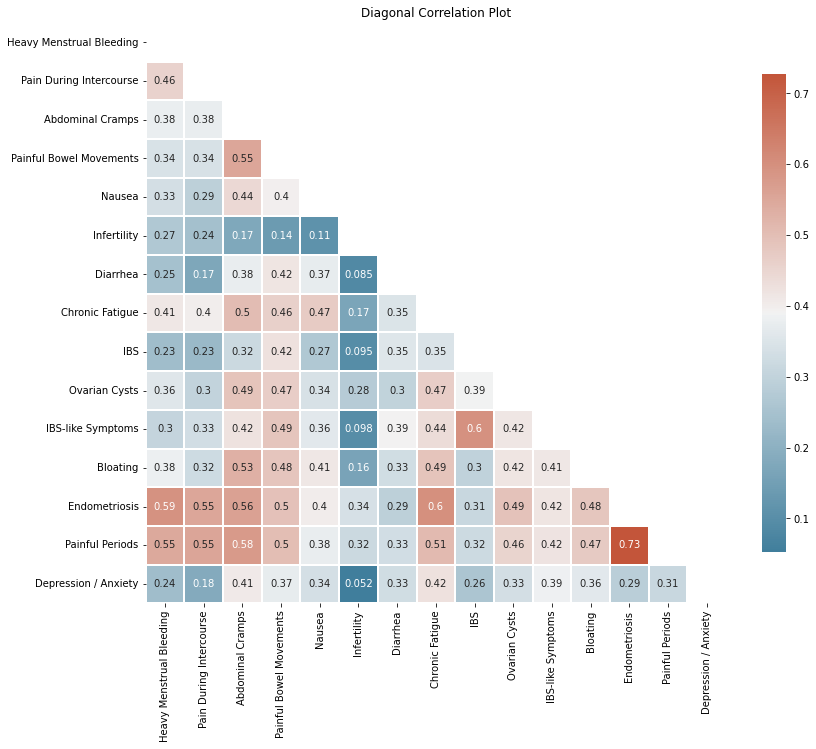

In [28]:
# Correlation matrix between columns and plots of each column value with 
# respect to 'Endometriosis'

plt.figure(figsize=(13,11))
corr = data_bool.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.title('Diagonal Correlation Plot')
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            cmap=sns.diverging_palette(230, 20, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8});

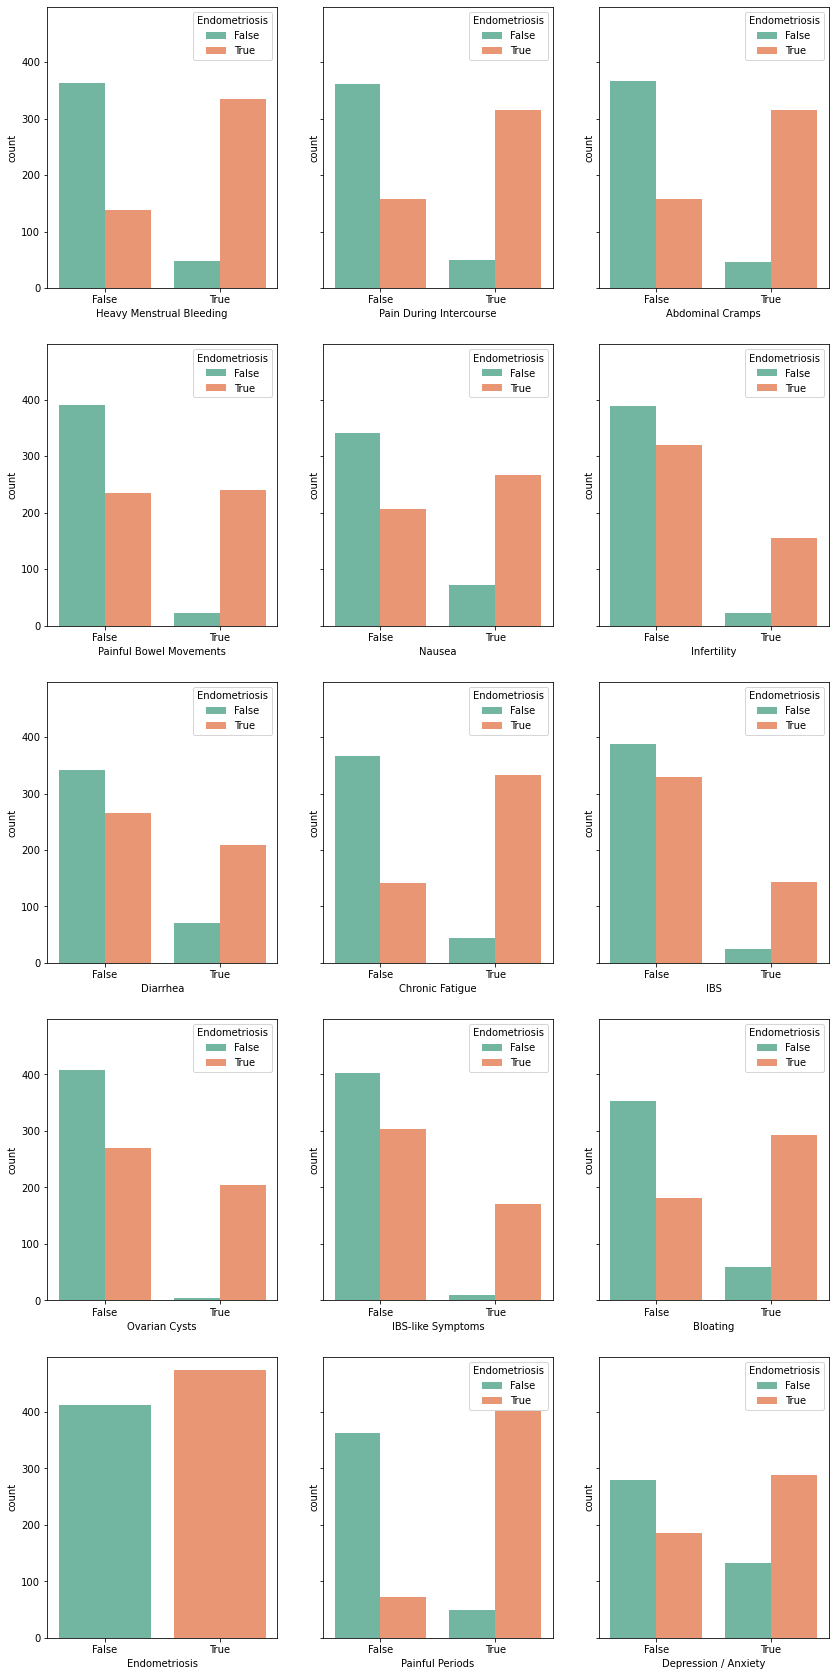

In [29]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 30), sharey=True)
axes = [axis for subl in axes for axis in subl]
for col, ax in zip(data_bool.columns, axes):
    if col != 'Endometriosis':
        sns.countplot(x=col, hue="Endometriosis", data=data_bool, ax=ax, palette="Set2")
    else:
        sns.countplot(x=col, data=data_bool, ax=ax, palette="Set2")

## **Network Structure and Parameter Learning** <a name="Network-Structure-and-Parameter-Learning"></a>

In addition to the nodes representing symptoms and comorbidities we introduced above, we also decided to include two common risk factors for Endometriosis, namely Family History and Invasive Pelvic Procedure. Note that they were not included in our dataset and there was no way to derive them from the other columns in the DataFrame, thus they had to be treated as latent variables. However, using some previous literature - specifically [(Collins, 2020)](#Collins) and [(Ashrafi et al, 2016)](#Ashrafi) - we were able to get some prior probabilities for them, which we'll employ when estimating the network's parameters.

### **Network Structure** <a name="Network-Structure"></a>

As shown in [(Collins, 2020)](#Collins), we used medical idioms in order to guide the structure of our bayesian model, producing a couple of different architectures which we'll now show and analyze. The initial proposed network is shown below.

In [3]:
RISK_FACTORS = ['Family History', 
                'Invasive Pelvic Procedure']
SYMPTOMS = ['Painful Bowel Movements', 
            'Diarrhea', 'Nausea', 
            'Bloating', 
            'Abdominal Cramps', 
            'IBS-like Symptoms', 
            'Heavy Menstrual Bleeding', 
            'Pain During Intercourse', 
            'Painful Periods']

def visualize_network(model, filename='../figures/final_network.html'):
    """
    Create a pyvis visualization of the given model, save it to filename and then
    display it using IPython.display.HTML.

    """
    net = Network(directed=True, notebook=True, layout=True, width=960)
    nodes = endobayes.nodes()
    edges = endobayes.edges()

    node_levels = [1 if node in RISK_FACTORS else 
                  2 if node == 'Endometriosis' else 4 
                  if node in ['Painful Bowel Movements', 'Diarrhea', 'Nausea', 'Bloating', 'Abdominal Cramps'] 
                  else 3 for node in nodes]
    node_colors = [COLORS.light_red if node == 'Endometriosis' else 
                  COLORS.light_yellow if node in RISK_FACTORS else 
                  COLORS.light_blue if node in SYMPTOMS 
                  else COLORS.light_purple for node in nodes]

    for node, level, color in zip(nodes, node_levels, node_colors):
        net.add_node(node, level=level, color=color)

    net.add_edges(edges)

    net.set_options(PYVIS_NETWORK_OPTIONS) 
    display_png_image(net, filename)
    plt.show()

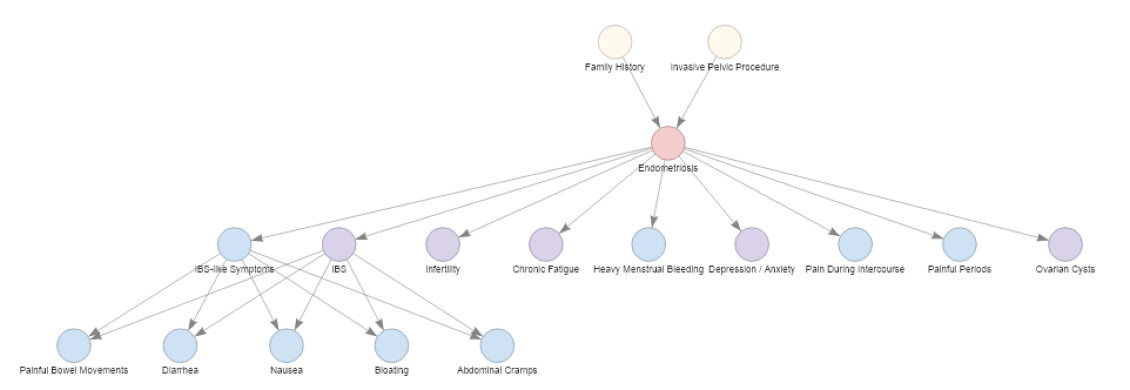

In [4]:
endobayes = BayesianModel([
    ('Family History', 'Endometriosis'),
    ('Invasive Pelvic Procedure', 'Endometriosis'),
    ('Endometriosis', 'IBS-like Symptoms'),
    ('Endometriosis', 'IBS'),
    ('Endometriosis', 'Infertility'),
    ('Endometriosis', 'Chronic Fatigue'),
    ('Endometriosis', 'Heavy Menstrual Bleeding'),
    ('Endometriosis', 'Depression / Anxiety'),
    ('Endometriosis', 'Pain During Intercourse'),
    ('Endometriosis', 'Painful Periods'),
    ('Endometriosis', 'Ovarian Cysts'),
    ('IBS-like Symptoms', 'Painful Bowel Movements'),
    ('IBS-like Symptoms', 'Diarrhea'),
    ('IBS-like Symptoms', 'Nausea'),
    ('IBS-like Symptoms', 'Bloating'),
    ('IBS-like Symptoms', 'Abdominal Cramps'),
    ('IBS', 'Painful Bowel Movements'),
    ('IBS', 'Diarrhea'),
    ('IBS', 'Nausea'),
    ('IBS', 'Bloating'),
    ('IBS', 'Abdominal Cramps')
    ], latents={'Family History', 'Invasive Pelvic Procedure'}
)

visualize_network(endobayes, filename='../figures/first_model.html')

As we can see, in the above model, some V-structures are present between `IBS-like Symptoms`, `IBS` and each of their five common children (`Nuasea`, `Painful Bowel Movements`, `Diarrhea`, `Bloating` and `Abdominal Cramps`), which means that we are considering `IBS` and `IBS-like Symptoms` to be mutually independent - an assumption that doesn't really reflect our reality. Due to this observation, we decided to propose another network structure, which is shown below:

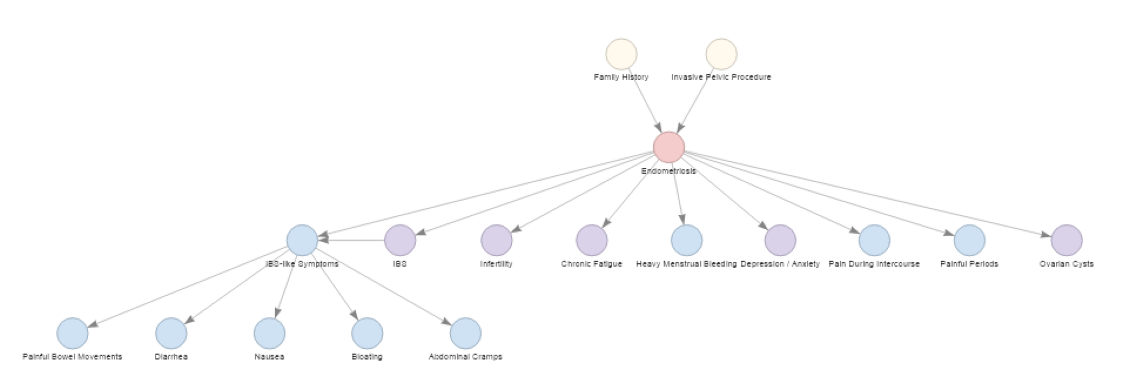

In [5]:
endobayes = BayesianModel([
    ('Family History', 'Endometriosis'),
    ('Invasive Pelvic Procedure', 'Endometriosis'),
    ('Endometriosis', 'IBS-like Symptoms'),
    ('Endometriosis', 'IBS'),
    ('Endometriosis', 'Infertility'),
    ('Endometriosis', 'Chronic Fatigue'),
    ('Endometriosis', 'Heavy Menstrual Bleeding'),
    ('Endometriosis', 'Depression / Anxiety'),
    ('Endometriosis', 'Pain During Intercourse'),
    ('Endometriosis', 'Painful Periods'),
    ('Endometriosis', 'Ovarian Cysts'),
    ('IBS-like Symptoms', 'Painful Bowel Movements'),
    ('IBS-like Symptoms', 'Diarrhea'),
    ('IBS-like Symptoms', 'Nausea'),
    ('IBS-like Symptoms', 'Bloating'),
    ('IBS-like Symptoms', 'Abdominal Cramps'),
    ('IBS', 'IBS-like Symptoms')
    ], latents={'Family History', 'Invasive Pelvic Procedure'}
)

visualize_network(endobayes)

### **Parameter Learning** <a name="Parameter-Learning"></a>

When learning the model's parameters, we had to decide how to deal with the latent variables: traditionally, their CPTs can be estimated from the available data using the Expectation Maximization algorithm, however, in our case, we were able to get some estimates from the literature. Thus, some of our network parameters need to be learned from data, while the others can be manually inserted. 

Therefore, we tried three different approaches:
*   We first tried to generate fictitious columns in our dataset for the missing nodes, using $P(Family\ History\ |\ Endometriosis)$ and $P(Invasive\ Pelvic\ Procedure\ |\ Endometriosis)$ which we got from the literature. Then we estimated the model's CPTs from the augmented dataset using a Bayesian Estimator. Note that we choose not to use a Maximum Likelihood Estimator (MLE), as it's known to sometimes overfit in case of small datasets: indeed, we might be providing too few observations, which make the frequencies computed by MLE not representative of the population. The Bayesian Estimator instead, uses a prior distrubution in order not to rely only on the input data, and is thus intrinsically more robust than the MLE. Among the priors available in pgmpy we choose BDeu, which generates N uniform samples for each variable to compute the pseudo-counts.
*   Then we simply tried to use Expectation Maximization to estimate the latent CPTs from the available data. However, as already pointed out, our two risk factors are not easy to estimate just from their associated condition and its symptoms, thus this approach often resulted in CPTs which were extremely different from those found in the literature and which, since the process is randomized, varied quite a lot with different random seeds.
*   The final approach we used is based on a modified implementation of the Expectation Maximization algorithm provided by pgmpy, which can be found in `parameter_estimators.py`. It now takes into consideration any CPT already manually added to the network, instead of just replacing it with a random one. Basically, we are making it possible for the EM algorithm to accept manual CPT priors and start from those, instead of starting from random probabilities every time.

These three approaches are shown below; note that the first one requires our network not to have any latent variables, as the Bayesian Estimator only works on models with all observed variables. Thus, we first need to re-define our `endobayes` model.

In [16]:
endobayes_no_latents = BayesianModel([
    ('Family History', 'Endometriosis'),
    ('Invasive Pelvic Procedure', 'Endometriosis'),
    ('Endometriosis', 'IBS-like Symptoms'),
    ('Endometriosis', 'IBS'),
    ('Endometriosis', 'Infertility'),
    ('Endometriosis', 'Chronic Fatigue'),
    ('Endometriosis', 'Heavy Menstrual Bleeding'),
    ('Endometriosis', 'Depression / Anxiety'),
    ('Endometriosis', 'Pain During Intercourse'),
    ('Endometriosis', 'Painful Periods'),
    ('Endometriosis', 'Ovarian Cysts'),
    ('IBS-like Symptoms', 'Painful Bowel Movements'),
    ('IBS-like Symptoms', 'Diarrhea'),
    ('IBS-like Symptoms', 'Nausea'),
    ('IBS-like Symptoms', 'Bloating'),
    ('IBS-like Symptoms', 'Abdominal Cramps'),
    ('IBS', 'IBS-like Symptoms')
    ])

In [17]:
# First approach
def generate_random_bool_values(endo_column, probs):
    # probs = [prob_true_and_endo, prob_true_and_not_endo]
    n_endo = endo_column.values.sum()
    n_not_endo = len(endo_column) - n_endo
    true_and_endo = np.ones(round(n_endo * probs[0]), dtype=np.int8)
    false_and_endo = np.zeros(round(n_endo * (1-probs[0])), dtype=np.int8)
    true_and_not_endo = np.ones(round(n_not_endo * probs[1]), dtype=np.int8)
    false_and_not_endo = np.zeros(round(n_not_endo * (1-probs[1])), dtype=np.int8)
    endo = np.concatenate([true_and_endo, false_and_endo])
    not_endo = np.concatenate([true_and_not_endo, false_and_not_endo])
    np.random.shuffle(endo)
    np.random.shuffle(not_endo)
    col = np.concatenate([not_endo, endo])
    return col

data_extended = data.copy()
data_extended = data.sort_values(by='Endometriosis')

data_extended['Family History'] = generate_random_bool_values(
    data_extended['Endometriosis'], 
    probs=[0.093, 0.012])
data_extended['Invasive Pelvic Procedure'] = generate_random_bool_values(
    data_extended['Endometriosis'], 
    probs=[0.768, 0.630])

estimator = BayesianEstimator(model=endobayes_no_latents, data=data_extended)

cpds = []
for node in endobayes_no_latents.nodes():
    cpds.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=100))
endobayes_no_latents.add_cpds(*cpds)

print('Checking the model...')
print(f'The model is {endobayes_no_latents.check_model()}\n\n')

for cpd in [cpd for cpd in endobayes_no_latents.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd, '\n')

Checking the model...
The model is True


CPD for Family History:
+-------------------+----------+
| Family History(0) | 0.899594 |
+-------------------+----------+
| Family History(1) | 0.100406 |
+-------------------+----------+ 

CPD for Endometriosis:
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Family History            | Family History(0)            | Family History(0)            | Family History(1)            | Family History(1)            |
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Invasive Pelvic Procedure | Invasive Pelvic Procedure(0) | Invasive Pelvic Procedure(1) | Invasive Pelvic Procedure(0) | Invasive Pelvic Procedure(1) |
+---------------------------+------------------------------+------------------------------+------------------------------+------

In [18]:
# Second approach
estimator = ExpectationMaximization(endobayes, data)
cpds = estimator.get_parameters(seed=4)
endobayes.add_cpds(*cpds)

print('Checking the model...')
print(f'The model is {endobayes.check_model()}\n\n')

for cpd in endobayes.get_cpds():
    print(cpd)

  6%|████▉                                                                             | 6/100 [00:09<02:29,  1.59s/it]

Checking the model...
The model is True


+-------------------+---------+
| Family History(0) | 0.64809 |
+-------------------+---------+
| Family History(1) | 0.35191 |
+-------------------+---------+
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Family History            | Family History(0)            | Family History(0)            | Family History(1)            | Family History(1)            |
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Invasive Pelvic Procedure | Invasive Pelvic Procedure(0) | Invasive Pelvic Procedure(1) | Invasive Pelvic Procedure(0) | Invasive Pelvic Procedure(1) |
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Endometriosis(0)          

In [19]:
# Remove the cpds we found with the second approach and check that the model
# has no cpds anymore
cpds = endobayes.get_cpds()
endobayes.remove_cpds(*cpds)

endobayes.get_cpds()

[]

In [21]:
# Third and final approach: first we define the prior probabilities and add them
# to the netowrk

# True in 9.3% of the times, false in 90.7%
family_history_cpd = TabularCPD('Family History', 2, [[0.907], [0.093]],
                                state_names={'Family History': [0, 1]})

# True in 11.9% of the times, False in 88.1%
invasive_procedure_cpd = TabularCPD('Invasive Pelvic Procedure', 2, [[0.881], [0.119]], 
                                    state_names={'Invasive Pelvic Procedure': [0, 1]})

endobayes.add_cpds(family_history_cpd, invasive_procedure_cpd)
for cpd in endobayes.get_cpds():
    print(cpd)

+-------------------+-------+
| Family History(0) | 0.907 |
+-------------------+-------+
| Family History(1) | 0.093 |
+-------------------+-------+
+------------------------------+-------+
| Invasive Pelvic Procedure(0) | 0.881 |
+------------------------------+-------+
| Invasive Pelvic Procedure(1) | 0.119 |
+------------------------------+-------+


In [30]:
# Now let's use the new EMWithPriors implementation to estimate the other cpds

estimator = ExpectationMaximizationWithPriors(endobayes, data)
cpds = estimator.get_parameters()
endobayes.add_cpds(*cpds)

print('\nChecking the model...')
print(f'The model is {endobayes.check_model()}\n\n')
for cpd in endobayes.get_cpds():
    print(cpd)

Using provided prior for Family History.
Using provided prior for Invasive Pelvic Procedure.


  6%|████▉                                                                             | 6/100 [00:26<06:48,  4.34s/it]



Checking the model...
The model is True


+-------------------+----------+
| Family History(0) | 0.826704 |
+-------------------+----------+
| Family History(1) | 0.173296 |
+-------------------+----------+
+------------------------------+----------+
| Invasive Pelvic Procedure(0) | 0.779311 |
+------------------------------+----------+
| Invasive Pelvic Procedure(1) | 0.220689 |
+------------------------------+----------+
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Family History            | Family History(0)            | Family History(0)            | Family History(1)            | Family History(1)            |
+---------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
| Invasive Pelvic Procedure | Invasive Pelvic Procedure(0) | Invasive Pelvic Procedure(1) | Invasive Pelvic Pr

## **Network Analysis** <a name="Network-Analysis"></a>

We'll now analyze our final architecture in terms of markov blankets and active trails. Regarding the idependencies, we can see that the model presents a V-structure between `Ivasive Pelvic Procedure`, `Family History` and `Endometriosis`, which implies that the two risk factors are independent from each other - something quite reasonable in our application. Finally, note however that this independency is no longer guaranteed by the V-structure when the value for `Endometriosis `is known.

### **Markov Blankets** <a name="Markov-Blankets"></a>

The Markov Blanket for a given node consists in the set of its parents, children and children's parents. Once we know its blanket, every variable A becomes independent from any other node in the network. 

Below we display, for each variable, its node in light orange, the corresponding Markov Blanket in red and the remaining nodes in gray.

In [2]:
def show_markov_blanket(network, filename, initial_node=None, blanket=[]):
    net = Network(directed=True, notebook=True, layout=True, width=960)
    nodes = network.nodes()
    edges = network.edges()

    node_levels = [1 if node in RISK_FACTORS else 
                   2 if node == 'Endometriosis' else 4 
                   if node in ['Painful Bowel Movements', 'Diarrhea', 'Nausea', 'Bloating', 'Abdominal Cramps'] 
                   else 3 for node in nodes]
    node_colors = [COLORS.orange if node == initial_node else
                   COLORS.amaranth if node in blanket else 
                   COLORS.gray for node in nodes]
    
    for node, level, color in zip(nodes, node_levels, node_colors):     
        net.add_node(node, level=level, color=color)

    net.add_edges(edges)

    net.set_options(PYVIS_NETWORK_OPTIONS) 
    path = '../figures/markov_blankets/' + filename
    fig = display_png_image(net, path)
    return fig
        


Node:  Family History
Markov Blanket:  ['Invasive Pelvic Procedure', 'Endometriosis']


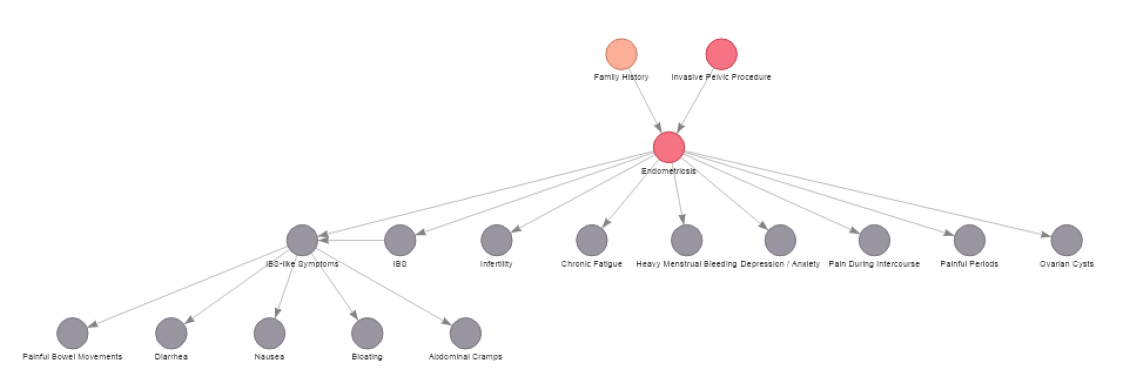


Node:  Endometriosis
Markov Blanket:  ['IBS', 'Chronic Fatigue', 'Ovarian Cysts', 'IBS-like Symptoms', 'Invasive Pelvic Procedure', 'Depression / Anxiety', 'Painful Periods', 'Heavy Menstrual Bleeding', 'Infertility', 'Family History', 'Pain During Intercourse']


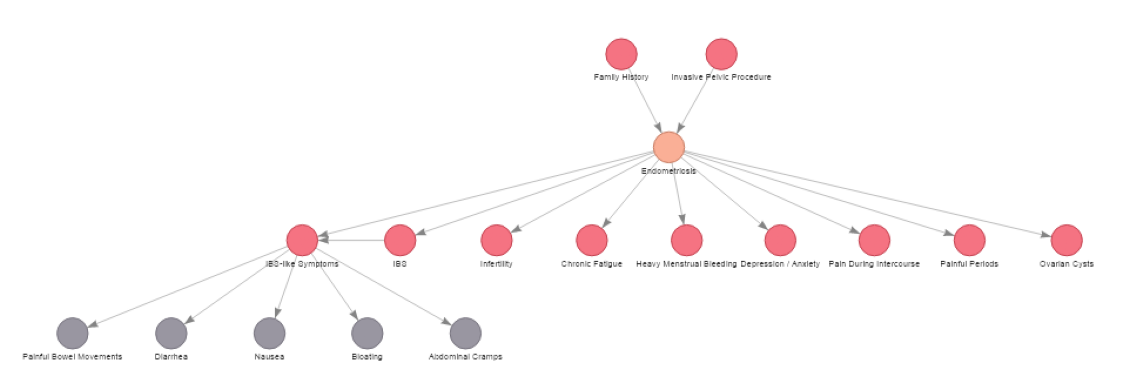


Node:  Invasive Pelvic Procedure
Markov Blanket:  ['Family History', 'Endometriosis']


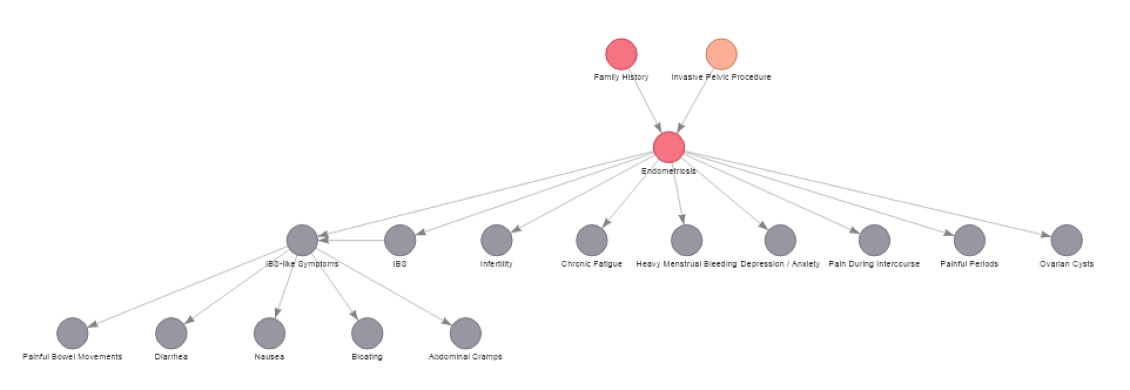


Node:  IBS-like Symptoms
Markov Blanket:  ['Nausea', 'IBS', 'Abdominal Cramps', 'Endometriosis', 'Painful Bowel Movements', 'Bloating', 'Diarrhea']


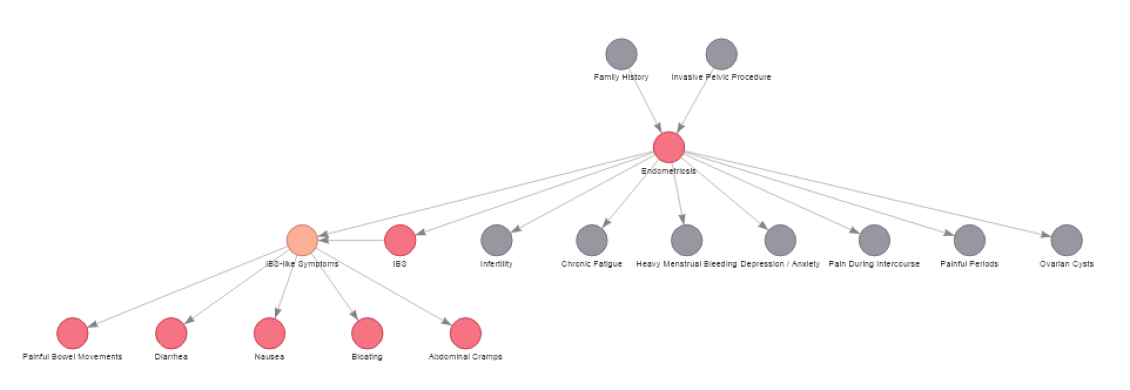


Node:  IBS
Markov Blanket:  ['IBS-like Symptoms', 'Endometriosis']


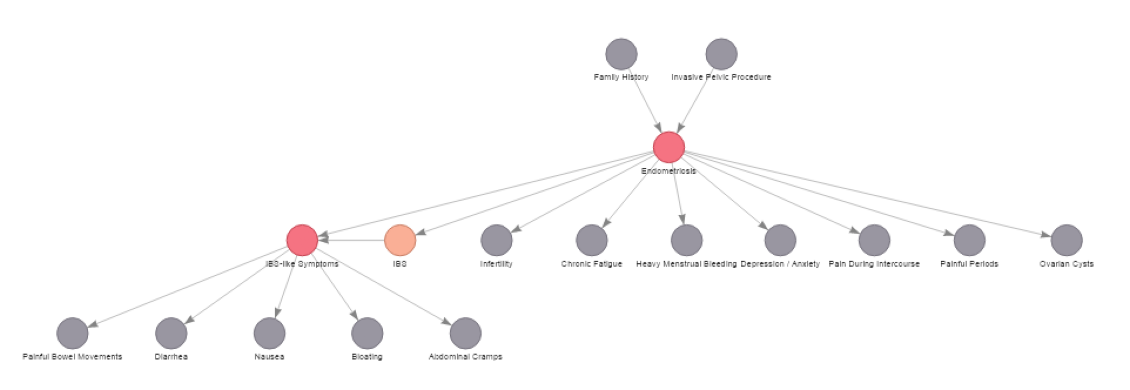


Node:  Infertility
Markov Blanket:  ['Endometriosis']


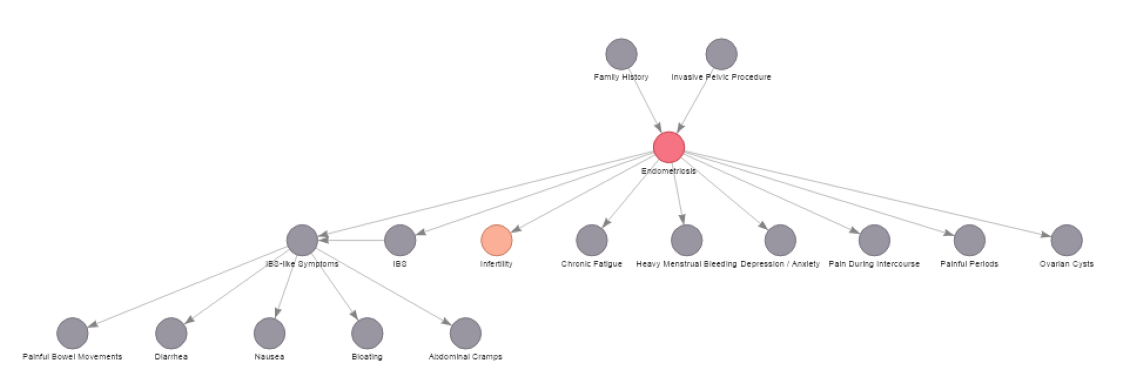


Node:  Chronic Fatigue
Markov Blanket:  ['Endometriosis']


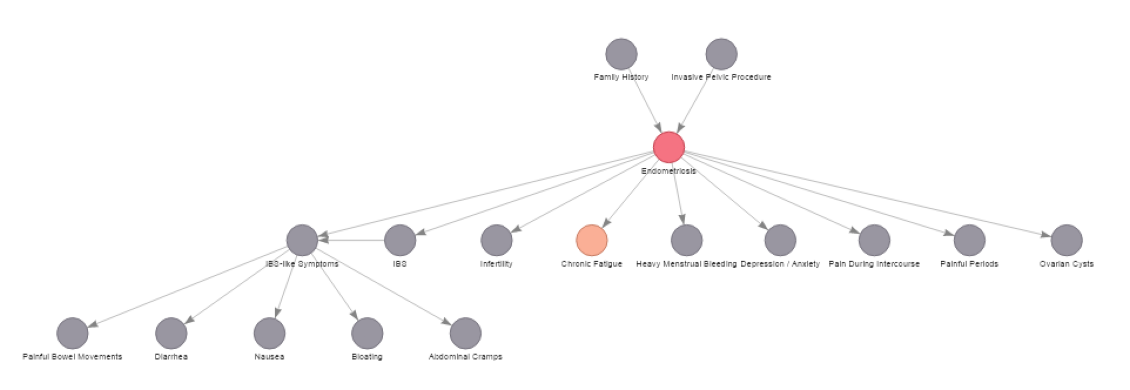


Node:  Heavy Menstrual Bleeding
Markov Blanket:  ['Endometriosis']


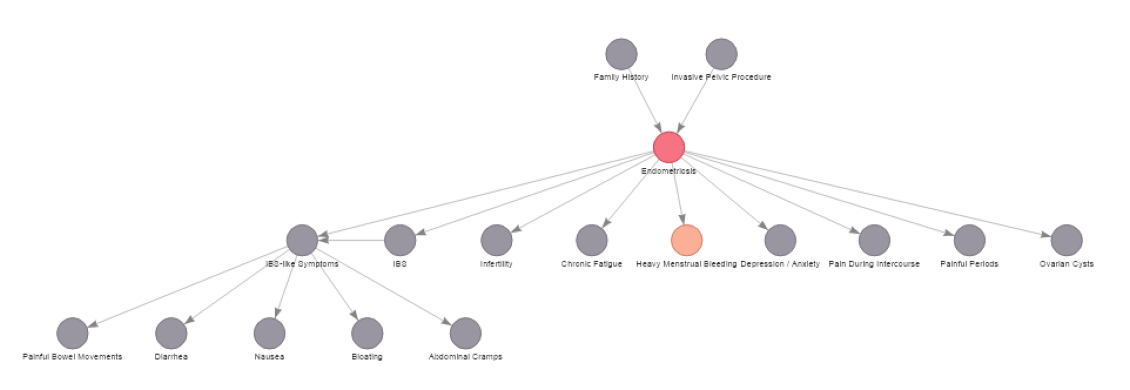


Node:  Depression / Anxiety
Markov Blanket:  ['Endometriosis']


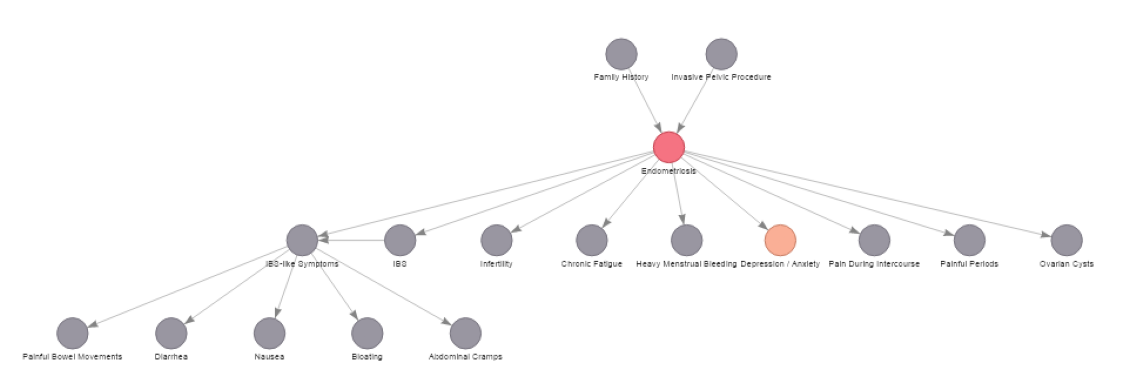


Node:  Pain During Intercourse
Markov Blanket:  ['Endometriosis']


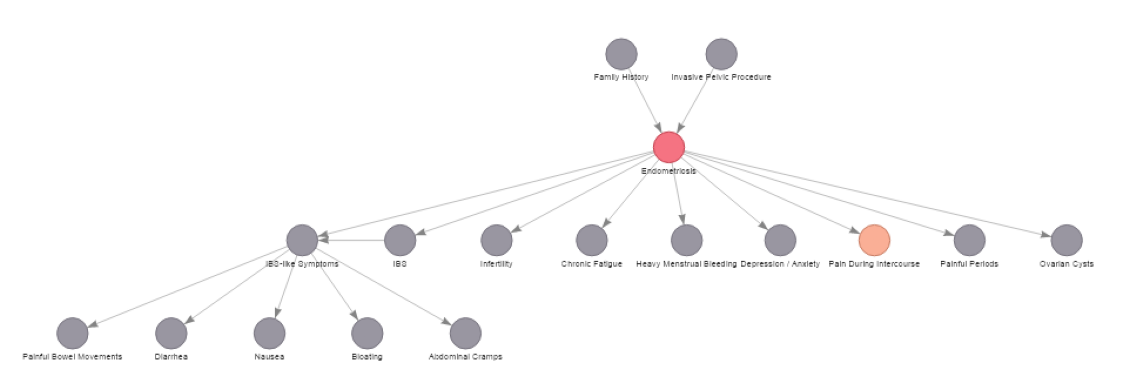


Node:  Painful Periods
Markov Blanket:  ['Endometriosis']


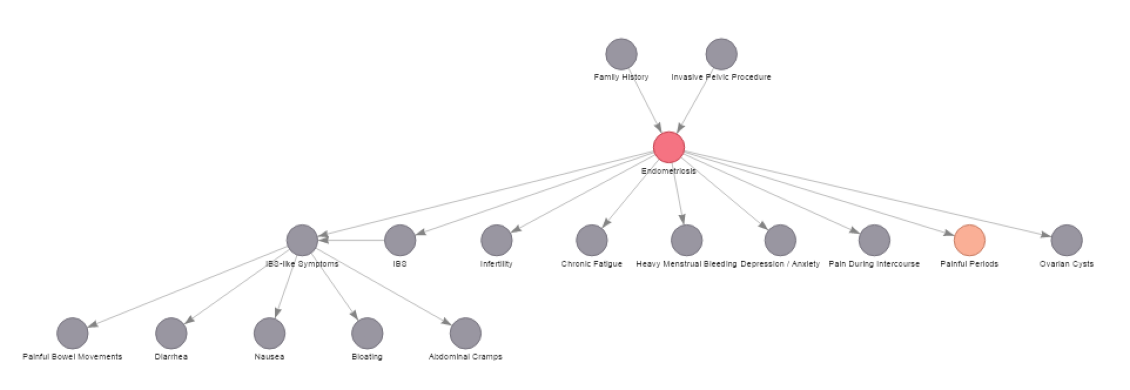


Node:  Ovarian Cysts
Markov Blanket:  ['Endometriosis']


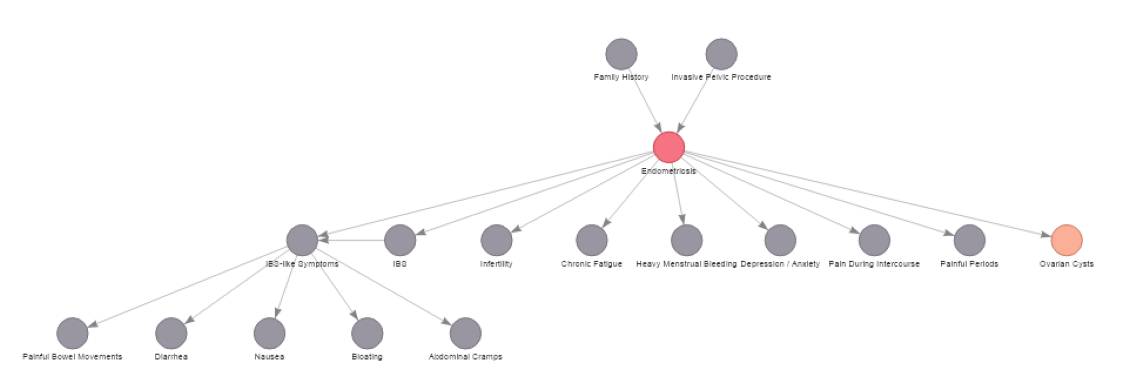


Node:  Painful Bowel Movements
Markov Blanket:  ['IBS-like Symptoms']


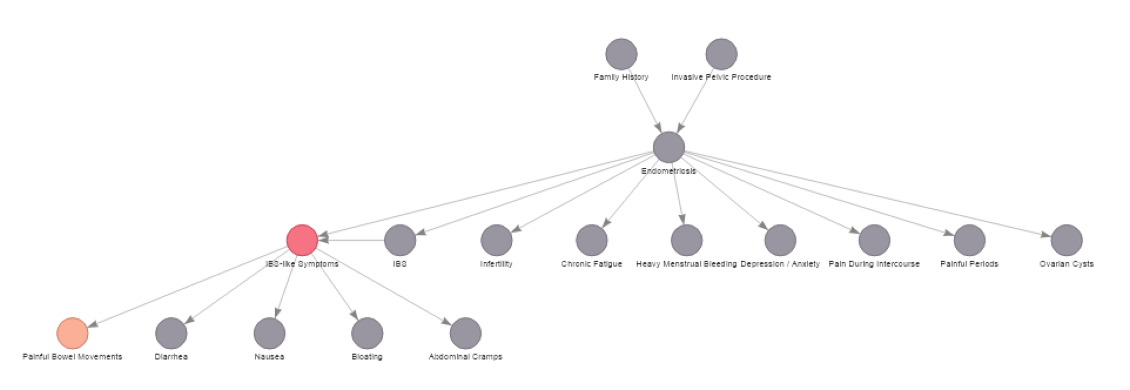


Node:  Diarrhea
Markov Blanket:  ['IBS-like Symptoms']


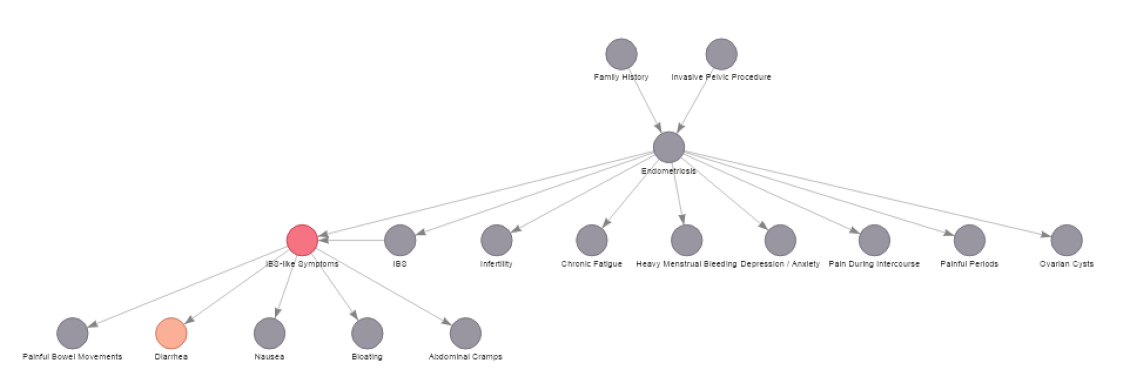


Node:  Nausea
Markov Blanket:  ['IBS-like Symptoms']


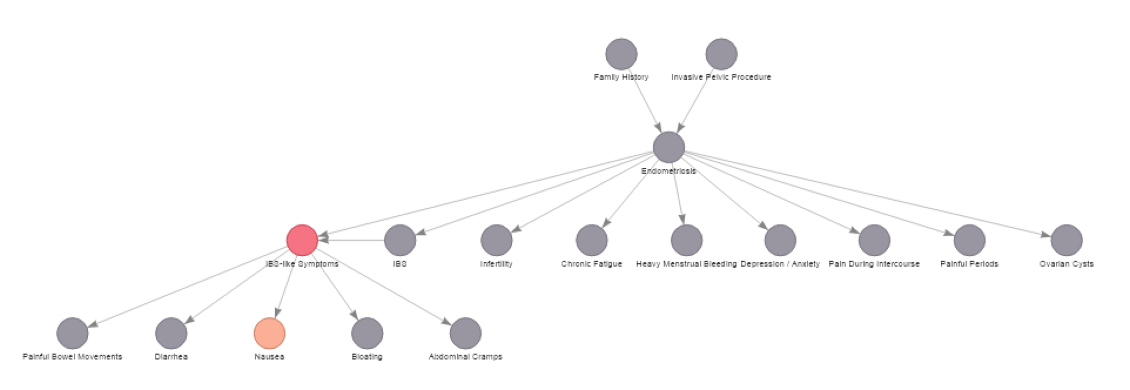


Node:  Bloating
Markov Blanket:  ['IBS-like Symptoms']


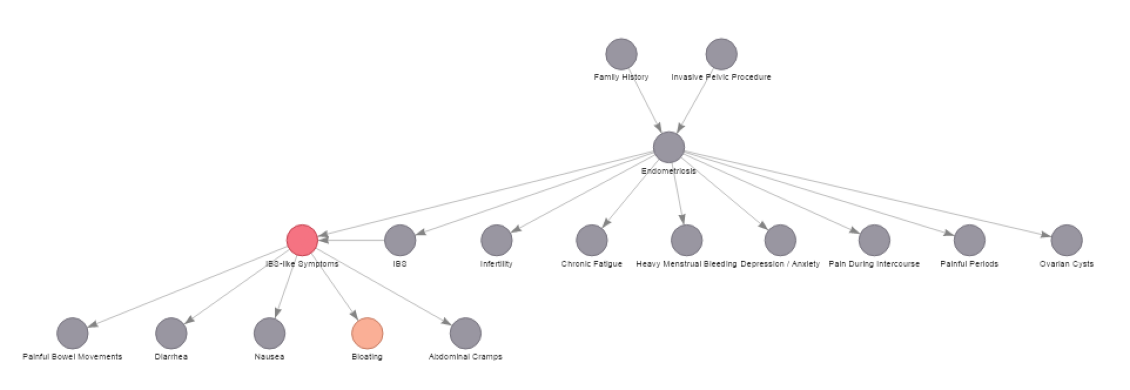


Node:  Abdominal Cramps
Markov Blanket:  ['IBS-like Symptoms']


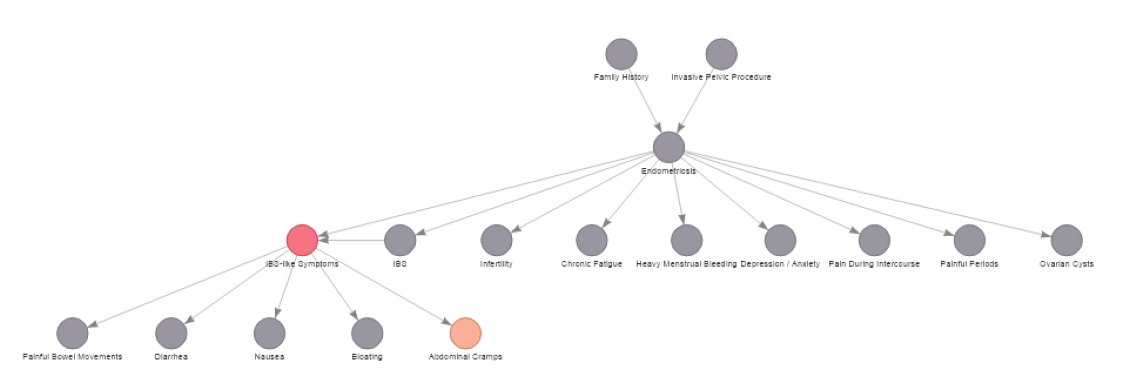

In [6]:
for node in endobayes.nodes():
    blanket = endobayes.get_markov_blanket(node)
    filename = f"blanket_{node.replace(' ', '_').replace('/', '')}.html"
    print('\nNode: ', node)
    print('Markov Blanket: ', blanket)
    fig = show_markov_blanket(endobayes,
                              filename=filename,
                              initial_node=node,
                              blanket=blanket)
    plt.show()

### **Active Trails** <a name="Active-Trails"></a>

When analyzing our network structure, we say that a path $X_1$ → $X_2$ → $\cdots$ → $X_k$ is an active trail when variables $O = \left\{ X_{i1},…,X_{in} \right\} $ are observed if for each consecutive triplet in the trail:
* The triplet is of the form $X_{i-1}$ → $X_i$ → $X_{i+1}$ and $X_i$ is not observed ($X_i \notin  O$). <br> Note that this must also be true when all the arrows point in the other direction and is called **head-to-tail** active trail.
* The triplet is of the form $X_{i-1}$ ← $X_i$ → $X_{i+1}$ and $X_i$ is not observed ($X_i \notin  O$). This is called **tail-to-tail** active trail.
* The triplet is of the form $X_{i-1}$ → $X_i$ ← $X_{i+1}$  and $X_i$ or one of its descendents is observed. This is called **head-to-head** active trail.

We also know that, two variables $X_i$ and $X_j$ in a bayesian network are independent if there's no active trail between them.

We'll now show some simple active trails in our network and how they can be broken by new incoming evidence. In the code cells below, the starting node of the trail is depicted in yellow, while the ending node is in blue: the arcs taking part in the path between them are green when the trail is active and red otherwise.

In [7]:
ACTIVE_TRAILS_PATH = '../figures/active_trails/'

def is_active_trail(model, start, end, observed):
    return end in model.active_trail_nodes(start, observed, include_latents=True)[start]

def show_active_trail(network, filename, trail=[], evidence=[]):
    net = Network(directed=True, notebook=True, layout=True, width=960)
    nodes = network.nodes()
    edges = network.edges()
    
    node_levels = [1 if node in RISK_FACTORS else 
                   2 if node == 'Endometriosis' else 4 
                   if node in ['Painful Bowel Movements', 'Diarrhea', 'Nausea', 'Bloating', 'Abdominal Cramps'] 
                   else 3 for node in nodes]
    
    node_colors = [COLORS.yellow if node == trail[0] else
                   COLORS.blue if node == trail[-1] else 
                   COLORS.light_pink if node in evidence else
                   COLORS.gray for node in nodes]
    
    # Check if there's an active path between initial and final node
    is_active = is_active_trail(network, start=trail[0], end=trail[-1], observed=evidence)
    msg = 'active' if is_active else 'not active'
    print('The provided trail is ' + msg + '.')
        
    for node, level, color in zip(nodes, node_levels, node_colors):     
        net.add_node(node, level=level, color=color)
    
    trail_edges = []
    for i in range(1, len(trail)):
        if (trail[i-1], trail[i]) in edges:
            trail_edges.append((trail[i-1], trail[i]))
        else:
            trail_edges.append((trail[i], trail[i-1]))
            
    edge_color = COLORS.green if is_active else COLORS.red
        
    for edge in edges:
        if edge in trail_edges:
            net.add_edge(edge[0], edge[1], color=edge_color, width=3)
        else:
            net.add_edge(edge[0], edge[1])
            
    net.set_options(PYVIS_NETWORK_OPTIONS) 
    fig = display_png_image(net, ACTIVE_TRAILS_PATH + filename)
    return fig

**Head-to-Tail active trail**

Without any evidence, we have two active trails going from `Endometriosis` to `Nausea`, which we'll show in the following cells. Note that, despite the arcs direction, these trails are also active when the information flows from `Nausea` to `Endometriosis`, (i.e.: when we are following an evidential resoning pattern instead of a causal one).

The provided trail is active.


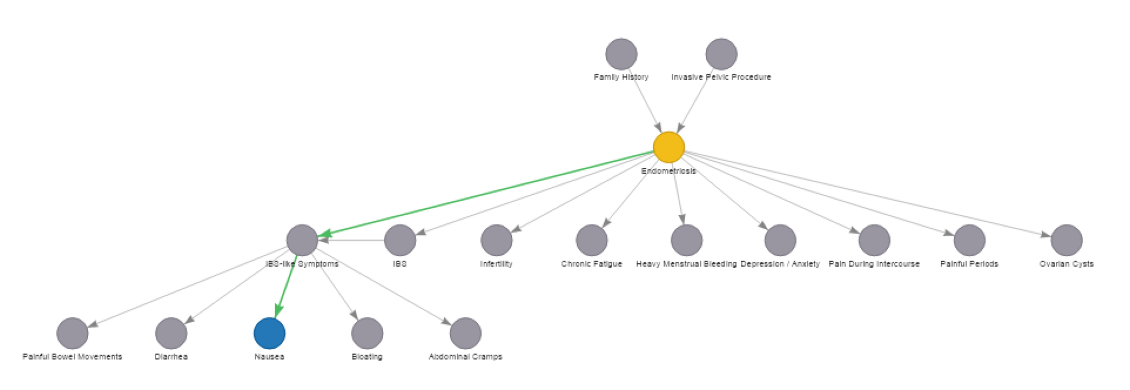

In [8]:
figure = show_active_trail(endobayes, 
                           filename='endo_nausea_active1.html',
                           trail=['Endometriosis', 'IBS-like Symptoms', 'Nausea'])
plt.show()

The provided trail is active.


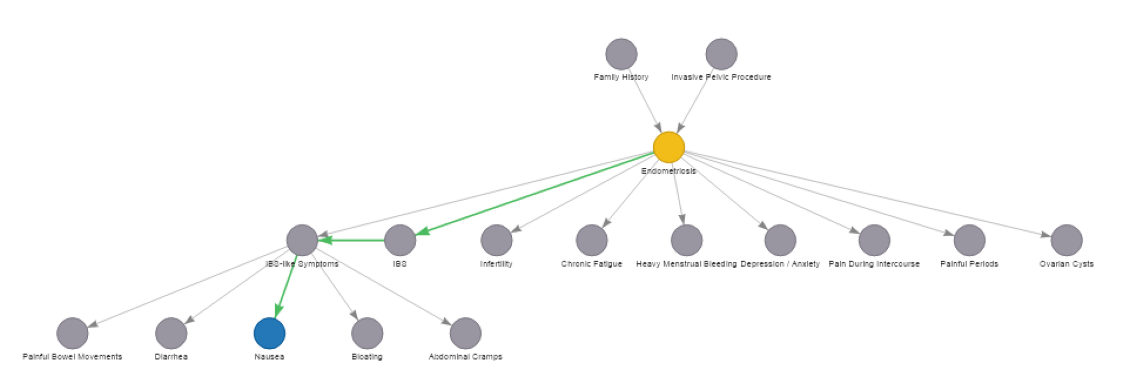

In [12]:
figure = show_active_trail(endobayes,
                           filename='endo_nausea_active2.html',
                           trail=['Endometriosis', 'IBS', 'IBS-like Symptoms', 'Nausea'])
plt.show()

If however we add `IBS` to our evidence, the second trail we've shown gets broken. Still, `Nausa` is reachable from `Endometriosis` - and vice versa - using the first trail: indeed, the information can still flow from `Endometriosis` to `Nausea` using the path `Endometriosis` -> `IBS-like Symptoms` -> `Nausea`, as we show now.

The provided trail is active.


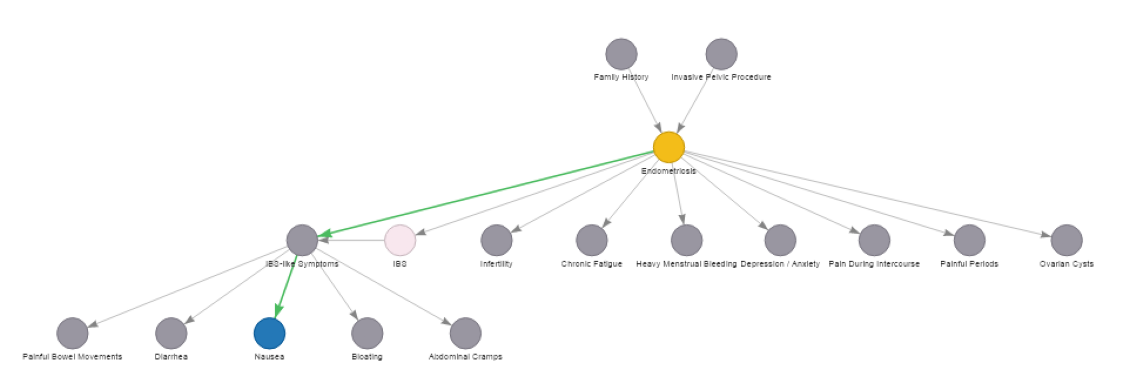

In [13]:
figure = show_active_trail(endobayes, 
                           filename='endo_nauesa_broken_by_ibs.html',
                           trail=['Endometriosis', 'IBS-like Symptoms', 'Nausea'], 
                           evidence=['IBS'])
plt.show()

Finally, having `IBS-like Symptoms` in our evidence breaks all the possible active trails between `Endoemtriosis` and `Nausea`, effectively making them independent one from the other once the evidence is known.

The provided trail is not active.


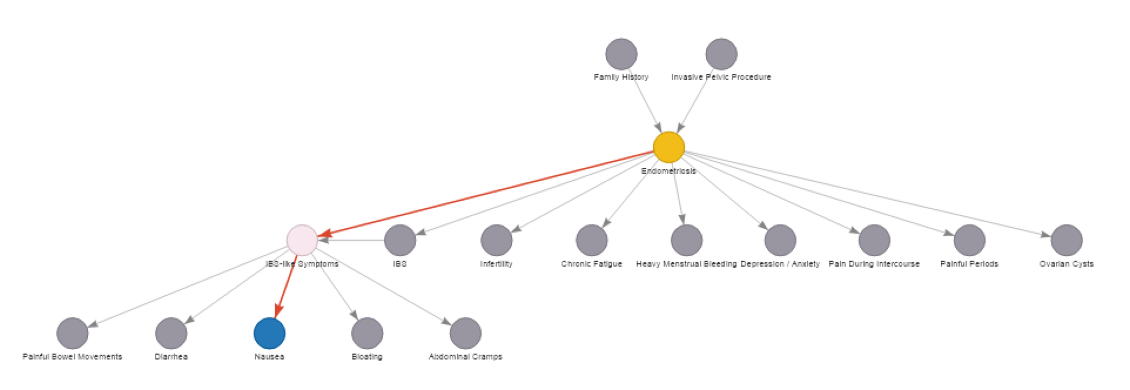

In [9]:
figure = show_active_trail(endobayes, 
                           filename='endo_nausea_broken1.html',
                           trail=['Endometriosis', 'IBS-like Symptoms', 'Nausea'], 
                           evidence=['IBS-like Symptoms'])
plt.show()

The provided trail is not active.


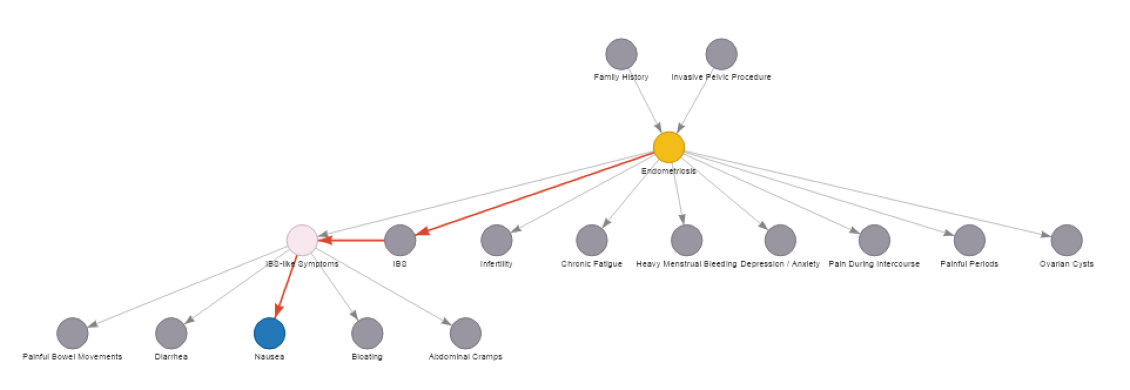

In [15]:
figure = show_active_trail(endobayes, 
                           filename='endo_nausea_broken2.html',
                           trail=['Endometriosis', 'IBS', 'IBS-like Symptoms', 'Nausea'], 
                           evidence=['IBS-like Symptoms'])
plt.show()

The provided trail is not active.


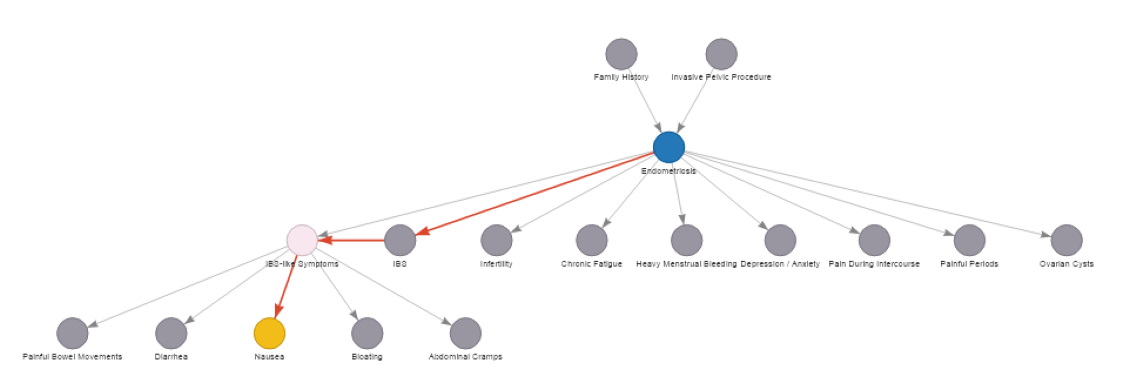

In [16]:
figure = show_active_trail(endobayes, 
                           filename='nausea_endo_broken.html',
                           trail=['Nausea', 'IBS-like Symptoms', 'IBS', 'Endometriosis'], 
                           evidence=['IBS-like Symptoms'])
plt.show()

**Tail-to-tail active trail:** 

Let's now consider the trail going from `Chronic Fatigue` to `Ovarian Cysts` (and vice versa), which is initially active without any evidence.

The provided trail is active.


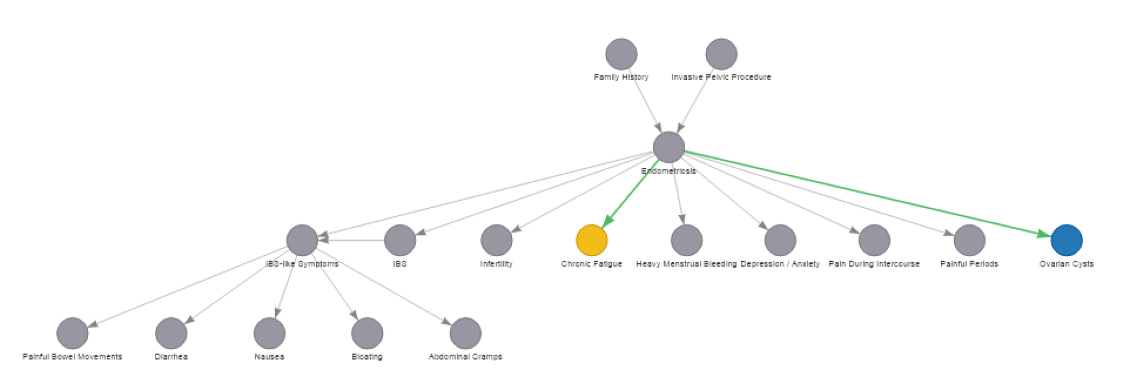

In [17]:
figure = show_active_trail(endobayes, 
                           filename='fatigue_cysts_active.html',
                           trail=['Chronic Fatigue', 'Endometriosis', 'Ovarian Cysts'])
plt.show()

We'll now show how knowing whether the patient suffers from `Endometriosis ` or not blocks this path and makes the two variables independent one from the other given the evidence.

The provided trail is not active.


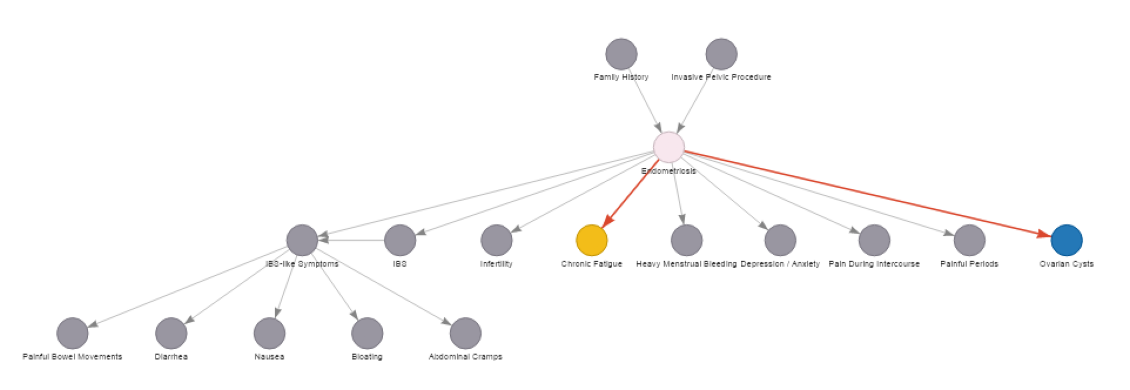

In [18]:
figure = show_active_trail(endobayes,
                           filename='fatigue_cysts_broken.html',
                           trail=['Chronic Fatigue', 'Endometriosis', 'Ovarian Cysts'], 
                           evidence=['Endometriosis'])
plt.show()

**Head-to-Head active trail:** 

Finally, let's consider the variables `Family History` and `Invasive Pelvic Procedure`. Without any evidence, they are marginally independent and there's no active trail between them. However, as we'll show, when we have `Endometriosis` among our evidence, the path between them gets unblocked and we have an active trail, meaning that they are no longer independent.

The provided trail is not active.


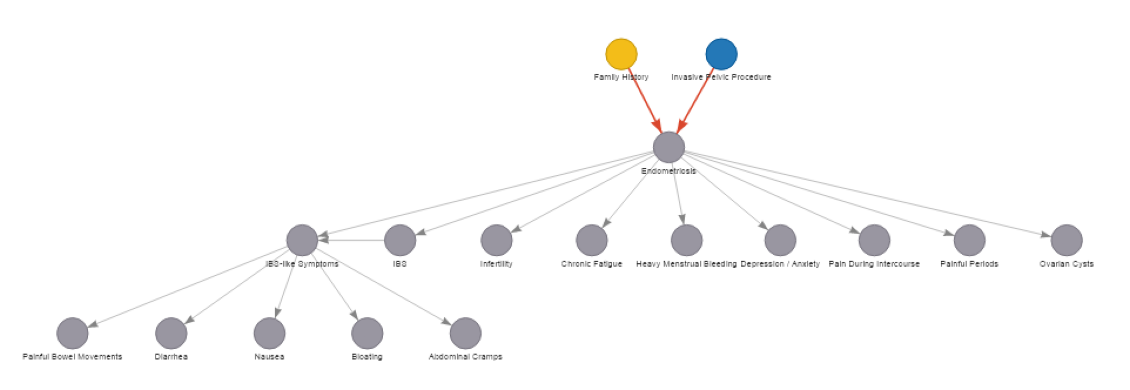

In [19]:
figure = show_active_trail(endobayes,
                           filename='family_pelvic_procedure_broken.html',
                           trail=['Family History', 'Endometriosis', 'Invasive Pelvic Procedure'])
plt.show()

The provided trail is active.


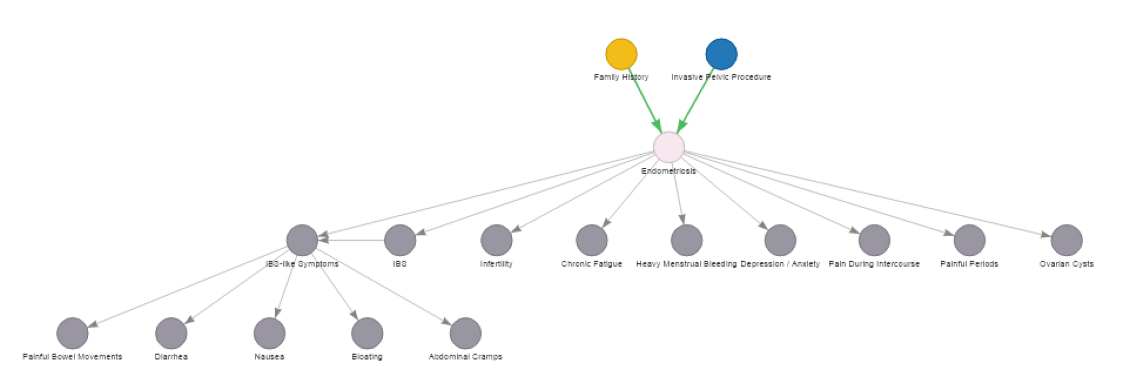

In [20]:
figure = show_active_trail(endobayes, 
                           filename='family_pelvic_procedure_active.html',
                           trail=['Family History', 'Endometriosis', 'Invasive Pelvic Procedure'], 
                           evidence=['Endometriosis'])
plt.show()

## **Inference** <a name="Inference"></a>

We'll now show how to do both exact and approximate inference on our network by using two simple case studies to mimic how this network can actually be used to help in diagnosis. In particular, exact inference on the model is done using pgmpy's `Variable Elimination` method, while for the approximate inference we choose to use `Gibbs Sampling`, a Markov chain Monte Carlo (MCMC) algorithm for generating a random sample from a posterior distribution.

### **Exact Inference: a case study** <a name="Exact-Inference"></a>

Our case study for exact inference will be the following: we need the probability that a patient has Endometriosis, kowing they feel pain during intercourse, are bloated and have a family history of endometriosis, but they do not have neither IBS nor painful periods. As already stated, we'll use the Variable Elimination method provided by pgmpy: the order in which the variables will be eliminated depends on the chosen heuristic function, which assigns a cost to the removal of every node a part from those taking part in query and evidence. The library provides 4 different heuristics:
* `MinFill`: the cost of removing the node is equal to the number of edges that need to be added to the network after its elimination.
* `MinNeighbors`: removing a node has a cost equal to the number of neighbors it has in the current architecture. 
* `MinWeight`: to every node is assigned a weight given by its domain cardinality; then, the cost of removing a node is equal to the product of the weights of its neighbors
* `WeightedMinFill`: to every edge is assigned a weight given by the product of the domain cardinality of its vertices; then, the cost of removing node A is given by the sum of the weights of the edges we'll need to add to the network after its elimination.

We'll now try to solve our simple case study using all the above heuristcs, in order to compare them in terms of performances and of the elimination order they lead to.

In [31]:
EVIDENCE = {'Pain During Intercourse': 1,
            'Painful Periods': 0,
            'Bloating': 1,
            'Family History': 1,
            'IBS': 0}

ordering_heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
inference = VariableElimination(endobayes)

def run_query(target_var, evidence, print_output=True):
    results = {
        'Heuristic': [],
        'Time': [],
        'Variable Order': []
    }
    for order in ordering_heuristics:
        if print_output:
            print('Using ' + order)
        start = time.time()
        prob = inference.query([target_var],
                              evidence,
                              elimination_order=order,
                              show_progress=False)
        end = time.time() - start
        results['Time'].append(end)
        results['Heuristic'].append(order)
        used_order = inference._get_elimination_order([target_var],
                                                      evidence,
                                                      elimination_order=order,
                                                      show_progress=False)
        results['Variable Order'].append(used_order)
        if print_output:
            print(prob)
            print('----- Query solved in {:.4f} seconds -----\n\n'.format(end))
    
    res = pd.DataFrame(results)
    return res

In [32]:
result = run_query(target_var='Endometriosis', evidence=EVIDENCE)
result

Using MinFill
+------------------+----------------------+
| Endometriosis    |   phi(Endometriosis) |
+==================+======================+
| Endometriosis(0) |               0.2135 |
+------------------+----------------------+
| Endometriosis(1) |               0.7865 |
+------------------+----------------------+
----- Query solved in 0.0453 seconds -----


Using MinNeighbors
+------------------+----------------------+
| Endometriosis    |   phi(Endometriosis) |
+==================+======================+
| Endometriosis(0) |               0.2135 |
+------------------+----------------------+
| Endometriosis(1) |               0.7865 |
+------------------+----------------------+
----- Query solved in 0.0293 seconds -----


Using MinWeight
+------------------+----------------------+
| Endometriosis    |   phi(Endometriosis) |
+==================+======================+
| Endometriosis(0) |               0.2135 |
+------------------+----------------------+
| Endometriosis(1) |     

,Heuristic,Time,Variable Order
0,MinFill,0.045313,"[Invasive Pelvic Procedure, IBS-like Symptoms]"
1,MinNeighbors,0.029250,"[Invasive Pelvic Procedure, IBS-like Symptoms]"
2,MinWeight,0.044179,"[Invasive Pelvic Procedure, IBS-like Symptoms]"
3,WeightedMinFill,0.038467,"[Invasive Pelvic Procedure, IBS-like Symptoms]"


As we can see, in this case the elimination order is exactly the same, no matter which heuristic we choose. Also, from the timing results, it seems that `MinNeighbors` might need less time in order to reach a conclusion; however, in order to verify whether this claim is true (i.e.: MinNeighbors consistently performs better than the other three heuristics for this query, and the results we got now aren't just due to chance), we shall now repeat the experiment twenty times per heuristics and average the results.

In [38]:
mean_times = {}
for heuristic in ordering_heuristics:
    mean_times[heuristic] = []

for _ in range(20):
    res = run_query(target_var='Endometriosis', 
                    evidence=EVIDENCE, 
                    print_output=False)
    for heuristic in ordering_heuristics:
        mean_times[heuristic].append(res[res['Heuristic'] == heuristic]['Time'].values[0])
  
mean_times = pd.DataFrame(mean_times)
mean_times.agg('mean')

MinFill            0.031145
MinNeighbors       0.031902
MinWeight          0.033308
WeightedMinFill    0.032409
dtype: float64

It's now easy to note that the difference in timing we could see before is not actually significant, as repeating each experiment 20 times and averaging the results produces the above timing information. We can thus conclude that, for our simple case study, all the variable ordering heruristics work equally well.

### **Approximate Inference: a case study** <a name="Approximate-Inference"></a>

For approximate inference, instead, our case study is the following: we need to know how likely it is for a patient to also have IBS when they have Endometriosis and suffer from nausea, bloating and ovarian cysts. As I said, the required probability will be approximated using Gibbs Sampling; in particular, we'll try many different sample sizes and - since the sampling process has a random component - we'll also repeat every sampling 10 times in order to average the results. Finally, we'll show the estimated mean probability for every sample size along with the 95% confidence interval.

In [84]:
def get_query_string(evidence_dict):
    query_string = ""
    for var, value in evidence_dict.items():
        query_string += "`" + var + "`" + ' == ' + str(value)
        if var != list(evidence_dict.keys())[-1]:
            query_string += " & "
    return query_string


def get_gibbs_prob(samples, query_var, query_evidence, pos=True):
    query_str = get_query_string(query_evidence)
    den = samples.query(query_str).shape[0]
    num = samples.query("`" + query_var + "`" + ' == ' + str(pos) + ' & ' + query_str).shape[0]
    return num / den if den else 0

In [85]:
# Let's first compute the real probability
real_prob = inference.query(['IBS'],
                {'Endometriosis': 1, 
                 'Nausea': 1, 
                 'Bloating': 1, 
                 'Ovarian Cysts': 1},
                show_progress=True)

print(real_prob)

Eliminating: IBS-like Symptoms: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]

+--------+------------+
| IBS    |   phi(IBS) |
+========+============+
| IBS(0) |     0.4531 |
+--------+------------+
| IBS(1) |     0.5469 |
+--------+------------+


In [92]:
CONFIDENCE = 0.95
RANGE = range(10, 4200, 100)

gibbs_sampler = GibbsSampling(endobayes)

def run_gibbs_experiment(query_var, 
                         query_evidence, 
                         pos=True, 
                         num_runs=10, 
                         sample_sizes=RANGE):
    data = {}
    for size in sample_sizes:
        probs = []
        for _ in range(num_runs):
            samples = gibbs_sampler.sample(size=size, include_latents=True)
            prob = get_gibbs_prob(samples, query_var, query_evidence, pos=pos)
            probs.append(prob)
            data[size] = probs
    data = pd.DataFrame(data)
    return data

In [94]:
def get_ci_and_mean(data, ci=0.95):
    mean = []
    lb = []
    ub = []
    for col in data.columns:
        m, c, s = data[col].agg(['mean', 'count', 'std'])
        mean.append(m)
        lb.append(m - (1 + ci)*s/math.sqrt(c))
        ub.append(m + (1 + ci)*s/math.sqrt(c))
    return mean, lb, ub

def display_gibbs_results(mean, lb, ub, true_prob, sample_sizes=RANGE):
    plt.fill_between(sample_sizes, ub, lb, color= 'tab:orange', alpha=.5, label = '95% CI')
    plt.axhline(y=true_prob, color='r', linestyle='--', label = 'True prob')
    plt.plot(sample_sizes, mean, linestyle='-', label = 'Gibbs prob')
    plt.legend(loc = 'best')
    plt.xlabel('Sample size')
    plt.ylabel('Average probability')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

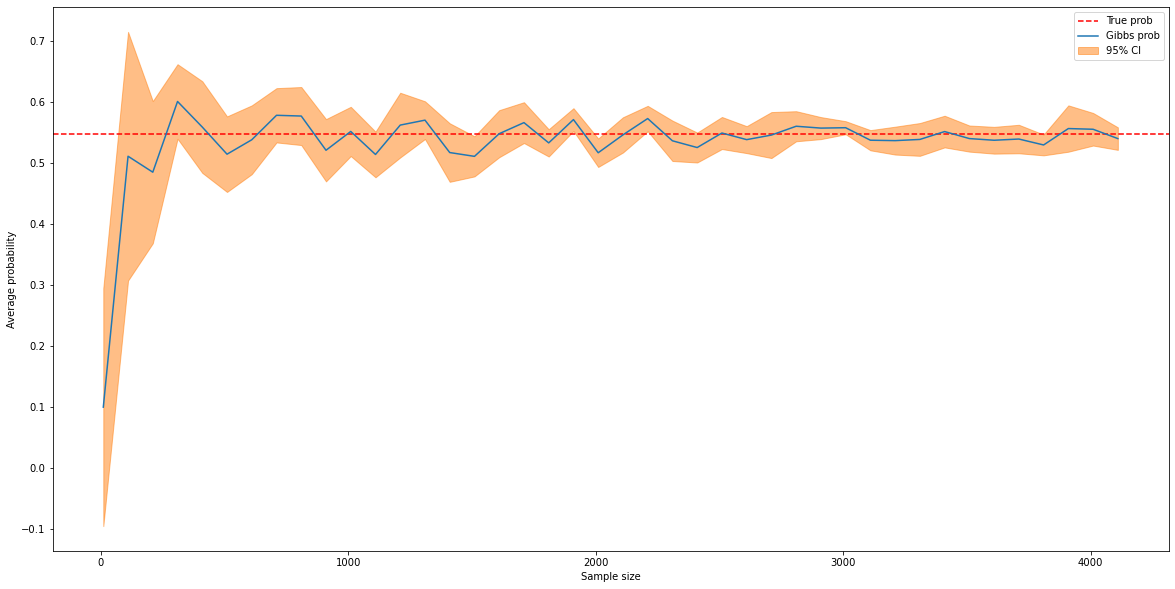

In [96]:
# Plotting Gibbs Sampling approximation of IBS=True
data = run_gibbs_experiment('IBS', {'Endometriosis': 1, 'Nausea': 1, 'Bloating': 1, 'Ovarian Cysts': 1}, pos=True)
ipd.clear_output(wait=True)
mean, lb, ub = get_ci_and_mean(data, ci=CONFIDENCE)
display_gibbs_results(mean, lb, ub, real_prob.values[1])

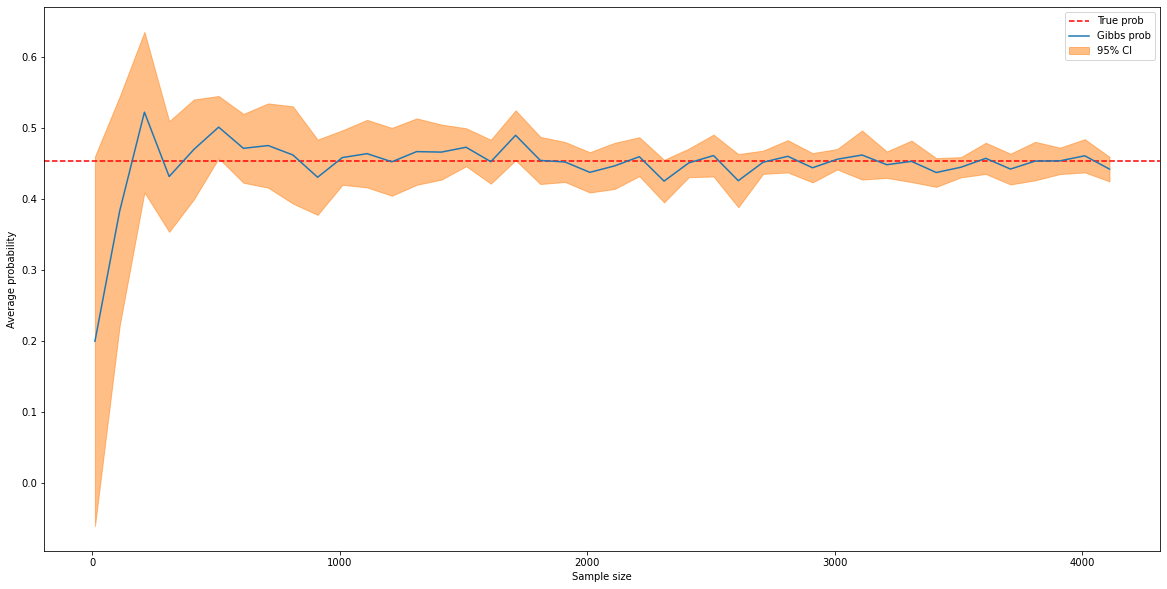

In [95]:
# Plotting Gibbs Sampling approximation of IBS=False
data = run_gibbs_experiment('IBS', {'Endometriosis': 1, 'Nausea': 1, 'Bloating': 1, 'Ovarian Cysts': 1}, pos=False)
ipd.clear_output(wait=True)
mean, lb, ub = get_ci_and_mean(data, ci=CONFIDENCE)
display_gibbs_results(mean, lb, ub, real_prob.values[0])

## References <a name="References"></a>
Ashrafi, M., Jahanian Sadatmahalleh, S., Akhoond, M. R. & Talebi, M., 2016. Evaluation of Risk Factors Associated with Endometriosis in Infertile Women. International Journal of Fertility and Sterility, 10(1), pp. 11-21 <a name="Ashrafi"></a>
<br> <br>
Rachel  Collins  and  Norman  Fenton.  “Bayesian  network  modelling  forearly diagnosis and prediction of Endometriosis”. doi:10.1101/2020.11.04.20225946.url:https://doi.org/10.1101/2020.11.04.20225946. <a name="Collins"></a>
<br> <br>
World  Health  Organisation.Endometriosis.https://www.who.int/news-room/fact-sheets/detail/endometriosis,  Last  accessed  on2021-07-20. 2021. <a name="WHO"></a>